In [124]:
import xarray as xr
import rioxarray
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob
import h5py
import cartopy
import pyart
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
# pyplot needed to plot the dataset, but animation only needed much further down.
from matplotlib import animation
%matplotlib inline

# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display

import sys
sys.path.append('~/PlotGallery')
from matplotlibconfig import basic
basic()

In [69]:
dict_hurricanes= {
    'Barry': {'datetime': [], 'points':[]},
    'Beta': {'datetime': [], 'points':[]},
    'Cindy': {'datetime': [], 'points':[]},
    'Delta': {'datetime': [], 'points':[]},
    'Hanna': {'datetime': [], 'points':[]},
    'Harvey': {'datetime': [], 'points':[]},
    'Imelda': {'datetime': [], 'points':[]},
    'Laura': {'datetime': [], 'points':[]},
    'Florence': {'datetime': [], 'points': []}
}

In [284]:
dict_hurricanes['Florence']['datetime'][0]

Timestamp('2018-08-30 06:00:00')

In [70]:
for event in dict_hurricanes.keys():
    fname= glob('tracks/%s/*_pts.shp'%(event))[0]
    pnts= gpd.read_file(fname)
    pnts.DTG= pd.to_datetime(pnts.DTG, format='%Y%m%d%H')
    dict_hurricanes[event]['datetime']= sorted(pnts.DTG.tolist())
    order= np.argsort(pnts.DTG.values)
    dict_hurricanes[event]['points']= list(zip(pnts.LON.values[order], pnts.LAT.values[order]))

In [61]:
AOI= gpd.read_file('area/great_extent.shp').to_crs('EPSG:4326')
# AOI['REGION']= 1
# AOI= AOI.dissolve(by='REGION')

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
lccProjParams = { 'central_latitude'   : 50.0, # same as lat_0 in proj4 string 
                  'central_longitude'  : -96.0, # same as lon_0
                  'standard_parallels' : (33.0, 45.0) # same as (lat_1, lat_2)
}

proj = cartopy.crs.LambertConformal(**lccProjParams)

# Soil moisture climatology

In [64]:
sm_clima=xr.open_rasterio('SM_climatology.tiff')

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


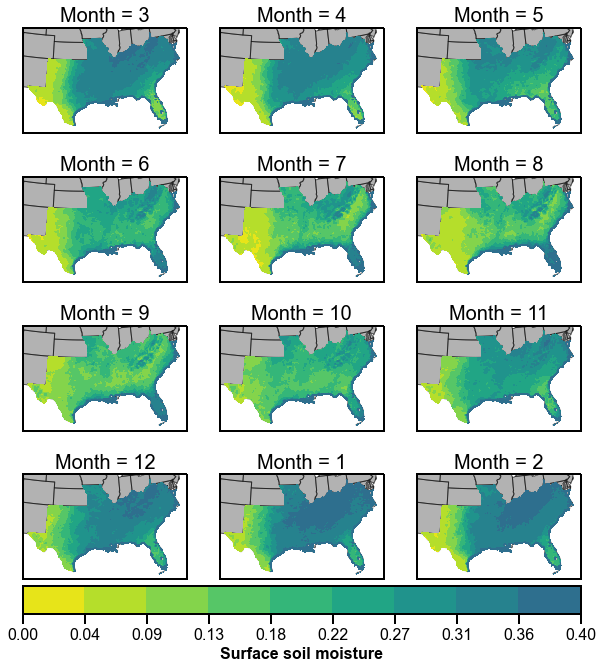

In [165]:
fig,axes= plt.subplots(4,3,subplot_kw={'projection': proj}, figsize=(10,13), gridspec_kw={'hspace':0.01})
for i, mon in enumerate([3,4,5,6,7,8,9,10,11,12,1,2]):
#     if mon<3:
    ax= axes[i//3, i%3]
    _sm= sm_clima.sel(band=mon)
    map=ax.contourf(_sm.x.values, _sm.y.values, _sm.values/100., cmap='viridis_r',
               transform=cartopy.crs.PlateCarree(),
                    vmin=0, vmax=0.4)
    ax.set_title('Month = %d'%mon)
    ax.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='grey', zorder=0)
cb= fig.colorbar(ax=axes, orientation='horizontal', mappable=map,pad=0.01)
cb.set_ticklabels(['%.2f'%num for num in np.linspace(0,0.4,10)])
cb.set_label('Surface soil moisture')
plt.tight_layout()
plt.show();

In [235]:
def get_IMERG(start, end):
    global AOI
    dr= pd.date_range(start,end, freq='6H')
    fnames= ['/media/scratch/ZhiLi/Final/%s.HDF5'%dt.strftime('%Y%m%d%H%M%S') for dt in dr]
    ds= []
    for i,fname in enumerate(fnames):
        with h5py.File(fname, 'r') as f:
            precip= f['Grid/precipitationCal'][:].squeeze().transpose(1,0)
#             precip= np.flip(precip, axis=0)
            lon= f['Grid/lon'][:].squeeze()
            lat= f['Grid/lat'][:].squeeze()
            da= xr.Dataset(
                    {'rain':(["time", 'y', 'x'], precip.reshape(1, 1800, 3600))},
                    {'time': [dr[i]], 'y': lat, 'x': lon})
        clipped= da.rain.rio.set_crs('EPSG:4326').rio.clip([AOI.geometry[0]], drop=True)
        ds.append(clipped)
            
    ds= xr.concat(ds, dim='time')
    return ds

In [200]:
ds= get_IMERG(dict_hurricanes['Harvey']['datetime'][0], dict_hurricanes['Harvey']['datetime'][-1])

In [206]:
ds= ds.where(ds!=0)

# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection':proj})

# Plot the initial frame. 
cax = ax.pcolormesh(ds.x.values,ds.y.values, ds[0,:,:], cmap=pyart.graph.cm.NWSRef, transform=cartopy.crs.PlateCarree(),
                    vmin=5, vmax=np.nanmax(ds)*0.8)
ax.add_feature(cartopy.feature.STATES, alpha=0.6)
fig.colorbar(mappable=cax, pad=0.01)
AOI.plot(ax=ax, color='None', ec='r',transform=cartopy.crs.PlateCarree())
# ax.plot()

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    time= ds.time[frame]

        
#     cax.set_array(ds[frame,:,:].values.reshape(-1))
    cax = ax.pcolormesh(ds.x.values,ds.y.values, ds[frame,:,:],
                        cmap=pyart.graph.cm.NWSRef,
                        transform=cartopy.crs.PlateCarree(),
                        vmin=5, vmax=np.nanmax(ds))
#     if time in dict_hurricanes['Harvey']['datetime']:
#         ax.plot(dict_hurricanes['Harvey']['datetime'])
#     ax.add_feature(cartopy.feature.STATES, alpha=0.6)
#     AOI.plot(ax=ax, color='None', ec='r',transform=cartopy.crs.PlateCarree())
    ax.set_title("Time = " + str(ds.coords['time'].values[frame])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=len(ds),       # Could also be iterable or list
    interval=200     # ms between frames
)
plt.close();

In [71]:
EVENT= 'Florence'
fnames= ['/media/scratch/ZhiLi/soil_moisture/CYGNSS/ucar_cu_cygnss_sm_v1_2018_%03d.nc'%dt.dayofyear for dt in dict_hurricanes[EVENT]['datetime']]
cygnss= xr.open_mfdataset(fnames)
cygnss['lat']= cygnss.latitude.values[0,:,0]
cygnss['lon']= cygnss.longitude.values[0,0,:]
cygnss= cygnss.rename({'lon': 'x', 'lat':'y'}).SM_subdaily.rio.set_crs('EPSG:4326').rio.clip([AOI.geometry.iloc[0]])
# ilons= (cygnss.lon<= -74) & (cygnss.lon>= -107)

cygnss_arr= np.zeros((cygnss.shape[0]*4,cygnss.shape[-2],cygnss.shape[-1]))
for i in range(cygnss.shape[0]*4):
    cygnss_arr[i,:,:]= cygnss[i//4,i%4,:,:]

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/geopandas/plotting.py:433: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.draw()


<GeoAxesSubplot:>

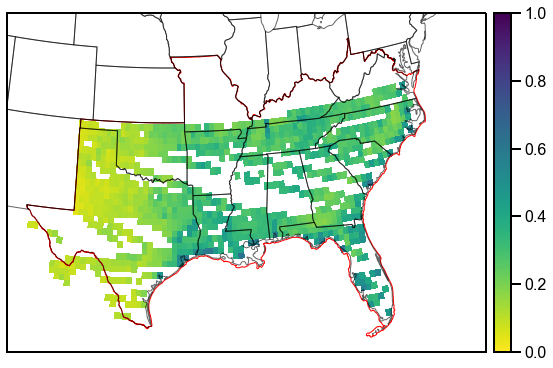

In [74]:
# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection':proj})

# Plot the initial frame. 
cax = ax.pcolormesh(cygnss.x.values,cygnss.y.values, cygnss_arr[0,:,:], cmap='viridis_r',
                  transform=cartopy.crs.PlateCarree(),
                    vmin=0, vmax=1)
aax= ax.plot(*list(dict_hurricanes[EVENT]['points'][0]))
ax.add_feature(cartopy.feature.STATES, alpha=0.6)
fig.colorbar(mappable=cax, pad=0.01)
AOI.plot(ax=ax, color='None', ec='r',transform=cartopy.crs.PlateCarree())
# ax.plot()
time_range= pd.date_range(pd.to_datetime(cygnss.time[0].values).strftime('%Y%m%d000000'),
                          (pd.to_datetime(cygnss.time[-1].values)+pd.Timedelta(days=1)).strftime('%Y%m%d000000'),
                          freq='6H', closed='left')
ax.set_extent([-107, -74, 24, 41])
# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    time= time_range[frame]
    cax = ax.pcolormesh(cygnss.x.values,cygnss.y.values, cygnss_arr[frame,:,:],
                        cmap='viridis_r',
                        transform=cartopy.crs.PlateCarree(),
                        vmin=0, vmax=1)    
    if time in dict_hurricanes[EVENT]['datetime']:
        section= pd.to_datetime(dict_hurricanes[EVENT]['datetime']).get_loc(time)
        locs= np.stack(dict_hurricanes[EVENT]['points'])[:section+1,:]
        aax= ax.plot(locs[:,0], locs[:,1], 'r-', linewidth=2, marker='o', transform=cartopy.crs.PlateCarree())


    ax.set_title("Time = " + str(time.strftime('%Y-%m-%dT%H')))
    ax.set_extent([-107, -74, 24, 41])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=len(cygnss_arr),       # Could also be iterable or list
    interval=200     # ms between frames
)
# plt.close();

HTML(ani.to_jshtml())

In [75]:
# SMAP
import datetime as dte
def read_SML3P_AM(filepath):
    ''' This function extracts lat, lon and soil moisture from SMAP L3 P HDF5 file.
    
    Parameters
    ----------
    filepath : str
        File path of a SMAP L3 HDF5 file
    Returns
    -------
    soil_moisture_am: numpy.array
    '''    
    with h5py.File(filepath, 'r') as f:
        # Extract data info
        group_id_am = 'Soil_Moisture_Retrieval_Data_AM'
        var_id_am = 'soil_moisture'
        flag_id_am = 'retrieval_qual_flag'
        soil_moisture_am = f[group_id_am][var_id_am][:,:]
        flag_am = f[group_id_am][flag_id_am][:,:]
        soil_moisture_am[soil_moisture_am==-9999.0]=np.nan;
#         soil_moisture_am[(flag_am>>0)&1==1]=np.nan
        filename = os.path.basename(filepath)
        yyyymmdd= filename.split('_')[5]
        yyyy = int(yyyymmdd[0:4]);        mm = int(yyyymmdd[4:6]);        dd = int(yyyymmdd[6:8])
        date=dte.datetime(yyyy,mm,dd,6)
        lon=f[group_id_am]['longitude'][:]
        lat= f[group_id_am]['latitude'][:]
    return soil_moisture_am,date,lon,lat

def read_SML3P_PM(filepath):
    ''' This function extracts lat, lon and soil moisture from SMAP L3 P HDF5 file.
    
    Parameters
    ----------
    filepath : str
        File path of a SMAP L3 HDF5 file
    Returns
    -------
    soil_moisture_am: numpy.array
    '''    
    with h5py.File(filepath, 'r') as f:
        # Extract data info
        group_id_am = 'Soil_Moisture_Retrieval_Data_PM'
        var_id_am = 'soil_moisture_pm'
        flag_id_am = 'retrieval_qual_flag_pm'
        soil_moisture_am = f[group_id_am][var_id_am][:,:]
        flag_am = f[group_id_am][flag_id_am][:,:]
        soil_moisture_am[soil_moisture_am==-9999.0]=np.nan;
#         soil_moisture_am[(flag_am>>0)&1==1]=np.nan
        filename = os.path.basename(filepath)
        yyyymmdd= filename.split('_')[5]
        yyyy = int(yyyymmdd[0:4]);        mm = int(yyyymmdd[4:6]);        dd = int(yyyymmdd[6:8])
        date=dte.datetime(yyyy,mm,dd,18)
        lon=f[group_id_am]['longitude_pm'][:]
        lat= f[group_id_am]['latitude_pm'][:]
    return soil_moisture_am,date,lon,lat

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
from functools import partial
import multiprocessing

def find_nearest_single(field, src_lons, src_lats, args): 
    tar_lon,tar_lat=args
    value= field[np.unravel_index(np.argmin((src_lons-tar_lon)**2 + (src_lats-tar_lat)**2), src_lons.shape)] \
              if (((src_lons-tar_lon)**2+ (src_lats-tar_lat)**2)**0.5).min()<0.3 else np.nan
#     values= np.array(values)
    
    return value

def find_avg_single(field, src_lons, src_lats, args): 
    tar_lon,tar_lat=args
    mask= ((src_lons - tar_lon)**2 + (src_lats - tar_lat)**2)**0.5 < (0.3734436/2)
    value= field[mask].mean()
    
    return value

def find_nearest(field, src_lons, src_lats, tar_lons, tar_lats):
    if len(src_lons.shape)!=2 or len(src_lats.shape)!=2:
        raise ValueError('input source lons and lats should be 2-dimensional.')
    
    func= partial(find_avg_single, field, src_lons, src_lats)
    args= [(_lon,_lat) for _lat in tar_lats for _lon in tar_lons]
    with multiprocessing.Pool(30) as pool:
        results= pool.map(func, args)
        
    return np.array(results).reshape(tar_lats.shape[0], tar_lons.shape[0])

In [77]:
sms= []
times= []
time_range_SMAP= pd.date_range(pd.to_datetime(dict_hurricanes[EVENT]['datetime'][0]),
                              pd.to_datetime(dict_hurricanes[EVENT]['datetime'][-1]),
                               freq='D')
for datetime in time_range_SMAP:
    fname= glob('/media/scratch/ZhiLi/SMAP/SMAP_L3_SM_P_E_%s*'%datetime.strftime('%Y%m%d'))[0]
    sm,sm_time,lon,lat=read_SML3P_AM(fname)
    
    if ((lon>cygnss.x.values.min()) & (lon<cygnss.x.values.max()) & (lat>cygnss.y.values.min()) &\
        (lat<cygnss.y.values.max())).any():
        sm_values= find_nearest(sm, lon, lat, cygnss.x.values, cygnss.y.values)
        sms.append(sm_values)
        times.append(sm_time)
    sm,time,lon,lat=read_SML3P_PM(fname)
    if ((lon>cygnss.x.values.min()) & (lon<cygnss.x.values.max()) & (lat>cygnss.y.values.min()) &
        (lat<cygnss.y.values.max())).any():    
        
        sm_values= find_nearest(sm, lon, lat, cygnss.x.values, cygnss.y.values)
        sms.append(sm_values)
        times.append(time)    

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/geopandas/plotting.py:433: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.draw()


<GeoAxesSubplot:>

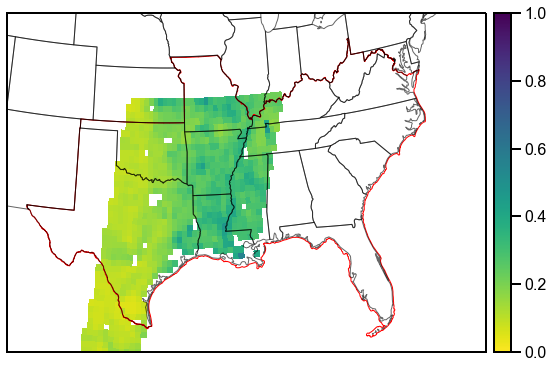

In [78]:
# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection':proj})

# Plot the initial frame. 
cax = ax.pcolormesh(cygnss.x.values, cygnss.y.values, sms[0], cmap='viridis_r',
                  transform=cartopy.crs.PlateCarree(),
                    vmin=0, vmax=1)
aax= ax.plot(*list(dict_hurricanes[EVENT]['points'][0]))
ax.add_feature(cartopy.feature.STATES, alpha=0.6)
fig.colorbar(mappable=cax, pad=0.01)
AOI.plot(ax=ax, color='None', ec='r',transform=cartopy.crs.PlateCarree())
# ax.plot()
time_range= pd.date_range(pd.to_datetime(cygnss.time[0].values).strftime('%Y%m%d000000'),
                          (pd.to_datetime(cygnss.time[-1].values)+pd.Timedelta(days=1)).strftime('%Y%m%d000000'),
                          freq='6H', closed='left')
ax.set_extent([-107, -74, 24, 41])
# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    time= times[frame]
    cax = ax.pcolormesh(cygnss.x.values, cygnss.y.values, sms[frame],
                        cmap='viridis_r',
                        transform=cartopy.crs.PlateCarree(),
                        vmin=0, vmax=1)    
    if time in dict_hurricanes[EVENT]['datetime']:
        section= pd.to_datetime(dict_hurricanes[EVENT]['datetime']).get_loc(time)
        locs= np.stack(dict_hurricanes[EVENT]['points'])[:section+1,:]
        aax= ax.plot(locs[:,0], locs[:,1], 'r-', linewidth=2, marker='o', transform=cartopy.crs.PlateCarree())


    ax.set_title("Time = " + str(time.strftime('%Y-%m-%dT%H')))
    ax.set_extent([-107, -74, 24, 41])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=len(times),       # Could also be iterable or list
    interval=200     # ms between frames
)
# plt.close();

HTML(ani.to_jshtml())

In [80]:
import netCDF4 as nc4
from netCDF4 import num2date, date2num

In [81]:
import time
# time_range= pd.date_range('20170816000000',
#                           '20170903000000',freq='6H', closed='left')
with nc4.Dataset('data/data_Florence.nc', 'w', format='NETCDF4') as f:
    f.history = "Created " + time.ctime(time.time())
    f.source = "netCDF4 python API"    
    f.description= 'Matched soil moisture products for CYGNSS and SMAP, by Allen'
    f.createDimension('time_cygnss', len(time_range))
    f.createDimension('time_smap', len(times))
    f.createDimension('lon', len(cygnss.x.values))
    f.createDimension('lat', len(cygnss.y.values))
    
    sm_cygnss=f.createVariable('sm_cygnss', 'f8', ('time_cygnss', 'lat', 'lon'), fill_value=-9999, zlib=True)
    sm_smap= f.createVariable('sm_smap', 'f8', ('time_smap', 'lat', 'lon'), fill_value=-9999, zlib=True)    
    lon= f.createVariable('lon', 'f4', 'lon', fill_value=-9999, zlib=True)
    lat= f.createVariable('lat', 'f4', 'lat', fill_value=-9999, zlib=True)    
    lon[:]= cygnss.x.values
    lat[:]= cygnss.y.values
    time_cygnss= f.createVariable('time_cygnss', 'f4', 'time_cygnss', fill_value=-9999, zlib=True)
    time_smap= f.createVariable('time_smap', 'f4', 'time_smap', fill_value=-9999, zlib=True)    
    time_cygnss[:]= [date2num(dt, 'hours since 2016-01-01 00:00:00', 'standard') for dt in time_range]
    time_cygnss.units= 'hours since 2016-01-01 00:00:00'
    time_cygnss.calendar='standard'
    time_smap[:]= [date2num(dt, 'hours since 2016-01-01 00:00:00', 'standard') for dt in times]
    time_smap.units= 'hours since 2016-01-01 00:00:00'
    time_smap.calendar='standard'    
    sms= np.stack(sms)
    sms[np.isnan(sms)]= -9999
    cygnss_arr[np.isnan(cygnss_arr)]=-9999
    sm_smap[:]= sms
    sm_cygnss[:]= cygnss_arr
    sm_smap.units= 'm3/m3'
    sm_cygnss.units= 'm3/m3'

<class 'netCDF4._netCDF4.Dimension'>: name = 'time_cygnss', size = 76

<class 'netCDF4._netCDF4.Dimension'>: name = 'time_smap', size = 38

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 83

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 46

In [82]:
ds= xr.open_dataset('data/data_Florence.nc').load()

In [386]:
ds.close()

In [241]:
# anomally
sm_sep= sm_clima.sel(band=9)
xx_sm,yy_sm = np.meshgrid(sm_sep.x.values, sm_sep.y.values)
sm_sep_regrid= find_nearest(sm_sep.values, xx_sm, yy_sm, ds.lon.values, ds.lat.values)
ds['sm_cygnss_ano']= ds.sm_cygnss - sm_sep_regrid
ds['sm_smap_ano']= ds.sm_smap - sm_sep_regrid

In [90]:
intersected_time= pd.to_datetime(ds.time_smap.values).intersection(pd.to_datetime(ds.time_cygnss.values))
intersected_ds= ds.sel(time_cygnss=intersected_time)

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


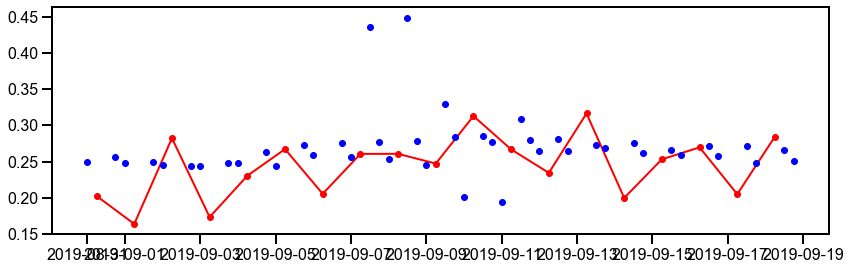

In [119]:
fig=plt.figure(figsize=(12,4))
ax= fig.add_subplot(111)
ax.plot(ds.mean(dim=['lon','lat']).time_smap.values, ds.mean(dim=['lon','lat']).sm_smap.values, color='r', marker='o')
ax.plot(ds.mean(dim=['lon','lat']).time_cygnss.values, ds.mean(dim=['lon','lat']).sm_cygnss.values,
        color='b', marker='o', linestyle='None')
# ax.set_xticks(ds.mean(dim=['lon','lat']).time_smap.values)
# ax.set_xticklabels(ds.mean(dim=['lon','lat']).time_smap.values, rotation=15)

In [92]:
from scipy.stats import spearmanr

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
cc = np.zeros(ds.sm_smap.shape[-2:])
p= np.zeros(ds.sm_smap.shape[-2:])
daily_SMAP= ds.sm_smap.resample({'time_smap': 'D'}).mean()
daily_cygnss= ds.sm_cygnss.resample({'time_cygnss': 'D'}).mean()
for x in range(len(intersected_ds.lat)):
    for y in range(len(intersected_ds.lon)):
        smp= daily_SMAP.isel(lon=y,lat=x).values
        cyg= daily_cygnss.isel(lon=y,lat=x).values
        mask= (~np.isnan(smp)) & (~np.isnan(cyg))
#         print(mask.sum())
        if mask.sum()>3:
            _cc, _p= spearmanr(smp[mask], cyg[mask])
        else:
            _cc= np.nan; _p= np.nan
        cc[x,y] =_cc
        p[x,y]= _p

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


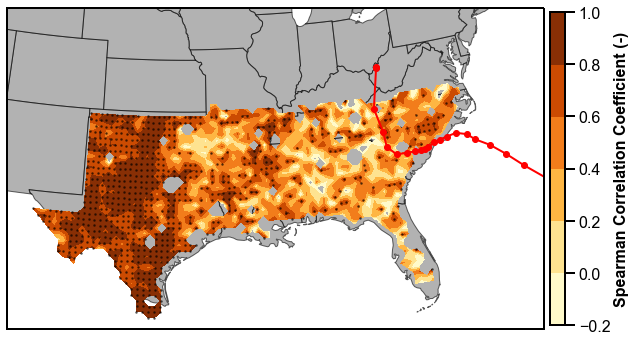

In [94]:
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':proj})
ax.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='grey', zorder=0)
# Plot the initial frame. 
cax = ax.contourf(ds.lon.values, ds.lat.values, cc, cmap='YlOrBr',
                  transform=cartopy.crs.PlateCarree(),
                    levels= np.arange(-0.2,1.2,0.2))
xx,yy= np.meshgrid(ds.lon.values, ds.lat.values)
sig_x= xx[p<0.05]
sig_y= yy[p<0.05]
ax.scatter(sig_x, sig_y, s=10, c='k', marker='.', alpha=0.5, transform=cartopy.crs.PlateCarree())
tracks= np.array(dict_hurricanes[EVENT]['points'])
ax.plot(tracks[:,0], tracks[:,1], 'r',marker='o', transform=cartopy.crs.PlateCarree())

cb= fig.colorbar(mappable=cax, pad=0.01, fraction=0.028)
cb.set_label('Spearman Correlation Coefficient (-)')
ax.set_extent([-107, -74, 24, 41]);

In [235]:
dur_landfall= pd.date_range('2018-09-10', '2018-09-17', freq='D')

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


20180917


/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


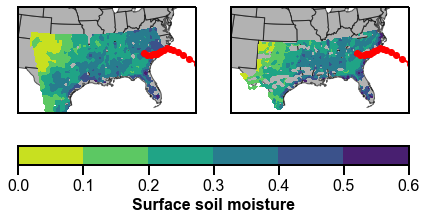

In [88]:
i=6

time= dur_landfall[i].strftime('%Y%m%d')
print(time)

iloc= pd.to_datetime(dict_hurricanes[EVENT]['datetime']).get_loc(dur_landfall[i],method='nearest')
tracks= np.array(dict_hurricanes[EVENT]['points'])
fig, axes= plt.subplots(1,2,figsize=(7, 4), subplot_kw={'projection': proj}, gridspec_kw={'hspace':0.01})
ax1= axes[0]
_sm= ds.sm_smap.sel(time_smap=time).mean(dim='time_smap').values
map=ax1.contourf(ds.lon.values, ds.lat.values, _sm.squeeze(),  cmap='viridis_r',
           transform=cartopy.crs.PlateCarree(),
                levels=np.arange(0,0.7,0.1))
ax1.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='grey', zorder=0)
ax1.plot(tracks[:iloc,0], tracks[:iloc,1], 'r',marker='o', transform=cartopy.crs.PlateCarree())
ax1.set_extent([-107, -74, 24, 41]);

ax2= axes[1]
_sm= ds.sm_cygnss.sel(time_cygnss=time).mean(dim='time_cygnss').values
map=ax2.contourf(ds.lon.values, ds.lat.values, _sm.squeeze(),  cmap='viridis_r',
           transform=cartopy.crs.PlateCarree(),
                levels=np.arange(0,0.7,0.1))
ax2.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='grey', zorder=0)
ax2.plot(tracks[:iloc,0], tracks[:iloc,1], 'r',marker='o', transform=cartopy.crs.PlateCarree())
ax2.set_extent([-107, -74, 24, 41]);
cb= fig.colorbar(ax=axes, orientation='horizontal', mappable=map)
cb.set_label('Surface soil moisture')
# for i in range(len(time)):
    

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


20180917


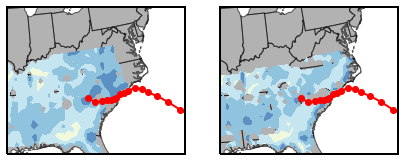

In [257]:
i=7

time= dur_landfall[i].strftime('%Y%m%d')
print(time)

iloc= pd.to_datetime(dict_hurricanes[EVENT]['datetime']).get_loc(dur_landfall[i],method='nearest')
tracks= np.array(dict_hurricanes[EVENT]['points'])
fig, axes= plt.subplots(1,2,figsize=(7, 4), subplot_kw={'projection': proj}, gridspec_kw={'hspace':0.01})
ax1= axes[0]
_sm= ds.sm_smap.sel(time_smap=time).mean(dim='time_smap').values - sm_sep_regrid/100.
map=ax1.contourf(ds.lon.values, ds.lat.values, _sm.squeeze(), cmap='RdYlBu',
           transform=cartopy.crs.PlateCarree(),
                levels=np.arange(-0.5,0.6,0.1))
ax1.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='grey', zorder=0)
ax1.plot(tracks[:iloc,0], tracks[:iloc,1], 'r',marker='o', transform=cartopy.crs.PlateCarree())
ax1.set_extent([-90.0, -73.18, 30.0, 40.63])

ax2= axes[1]
_sm= ds.sm_cygnss.sel(time_cygnss=time).mean(dim='time_cygnss').values - sm_sep_regrid/100.
map=ax2.contourf(ds.lon.values, ds.lat.values, _sm.squeeze(), cmap='RdYlBu',
           transform=cartopy.crs.PlateCarree(),
                levels=np.arange(-0.5,0.6,0.1))
ax2.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='grey', zorder=0)
ax2.plot(tracks[:iloc,0], tracks[:iloc,1], 'r',marker='o', transform=cartopy.crs.PlateCarree())
# ax2.set_extent([-107, -74, 24, 41]); # the whole domain
ax2.set_extent([-90.0, -73.18, 30.0, 40.63]) # Florence domain
# cb= fig.colorbar(ax=axes, orientation='horizontal', mappable=map)
# cb.set_label('Soil moisture anomaly')
# for i in range(len(time)):
    

In [215]:
from matplotlib.ticker import FormatStrFormatter

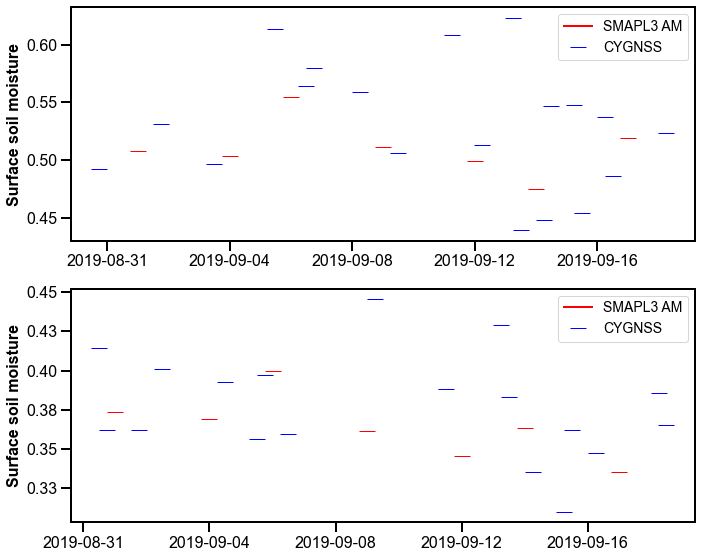

In [217]:
fig=plt.figure(figsize=(10,8))
ax= fig.add_subplot(211)
ax.plot(ds.time_smap.values, ds.sm_smap.values[:,10,68], color='r', marker='_', markersize=16, label='SMAPL3 AM')
ax.plot(ds.time_cygnss.values, ds.sm_cygnss.values[:,10,68],
        color='b', marker='_', linestyle='None', markersize=16, label='CYGNSS')
ax.set_xticks(ds.time_smap.values[::4])
ax.legend()
ax.set_ylabel('Surface soil moisture');
ax=fig.add_subplot(212)
ax.plot(ds.time_smap.values, ds.sm_smap.values[:,13,68], color='r', marker='_', markersize=16, label='SMAPL3 AM')
ax.plot(ds.time_cygnss.values, ds.sm_cygnss.values[:,13,68],
        color='b', marker='_', linestyle='None', markersize=16, label='CYGNSS')
ax.set_xticks(ds.time_smap.values[::4])
ax.yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))
ax.legend()
ax.set_ylabel('Surface soil moisture');
# ax.set_xticklabels(ds.mean(dim=['lon','lat']).time_smap.values, rotation=15)

# Retrieve gauges

In [492]:
import climata
from climata.snotel import StationHourlyDataIO, StationIO
import geopandas as gpd
from suds.client import Client
from suds.sudsobject import asdict, Object as SudsObject

In [455]:
soil_gauge_meta= pd.read_csv('data/site_meta.csv')
gdf_gauge= gpd.read_file('site_meta/site_meta.shp')

In [642]:
server= Client('https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL').service
fn = getattr(server, 'getHourlyData')

In [701]:
parse_dict={
    'stationTriplets': '2113:AL:SCAN',
    'elementCd': 'SMS',
    'beginDate': '2018-08-30',
    'endDate': '2018-09-18',
    'ordinal':1,
    'heightDepth': {'unitCd': 'in', 'value':-2}
}

res= fn(**parse_dict)

In [713]:
import pytz
import timezonefinder

tf = timezonefinder.TimezoneFinder()

def get_SM_query(triplet, lon, lat):
    parse_dict={
    'stationTriplets': triplet,
    'elementCd': 'SMS',
    'beginDate': '2018-08-30',
    'endDate': '2018-09-19',
    'ordinal':1,
    'heightDepth': {'unitCd': 'in', 'value':-2}
    }
    res= fn(**parse_dict)
    datetime= [row['dateTime'] for row in res[0]['values']]
    values= [row['value'] for row in res[0]['values']]
    local_tz= tf.certain_timezone_at(lat=lat, lng=lon)
    timezone = pytz.timezone(local_tz)
    to_utc= [pd.to_datetime(dt)+timezone.utcoffset(pd.to_datetime(dt)) for dt in datetime]
    df= pd.DataFrame(index=to_utc)
    df['sm']= values
    
    return df
    

In [775]:
df_gauge= pd.DataFrame(index=pd.date_range('2018-08-29', '2018-09-20', freq='H'))

In [778]:
for i in range(len(gdf_gauge)):
# if i==65:
# i=65
    if gdf_gauge.iloc[i].ID not in df_gauge.columns.tolist() and gdf_gauge.iloc[i].ID!=2231:
        try:
            print('Processing %s %s...'%(gdf_gauge.iloc[i].ID, gdf_gauge.iloc[i].Name))
            basin_id= gdf_gauge.iloc[i].HUC[:-1]
            gauge_id= gdf_gauge.iloc[i].ID
            lon= gdf_gauge.iloc[i].Longitude
            lat= gdf_gauge.iloc[i].Latitude
            triplet= StationIO(basin=basin_id)[0].stationtriplet
            _df= get_SM_query(triplet, lon, lat)
            df_gauge.loc[_df.index, gauge_id]= _df.values.squeeze()
            print('Success!')
        except Exception:
            print('Failed ...')
    else:
        print('%s Exist'%(gdf_gauge.iloc[i].ID))

Processing 2057 AAMU-JTG...
Success!
Processing 2076 Allen Farms...
Success!
Processing 2032 Beasley Lake...
Success!
Processing 2207 Beaumont...
Success!
Processing 2078 Bragg Farm...
Success!
Processing 2177 Broad Acres...
Failed ...
Processing 2224 Busby Farm...
Success!
Processing 2006 Bushland #1...
Failed ...
Processing 2195 CMRB LTAR-MO...
Success!
Processing 2223 Carver Farm...
Success!
Processing 2113 Cullman-NAHRC...
Success!
Processing 2174 Dee River Ranch...
Success!
Processing 2048 Dexter...
Success!
Processing 2077 Eastview Farm...
Success!
Processing 2220 Elsberry PMC...
Success!
Processing 2051 Everglades ARS...
Failed ...
Processing 2022 Fort Reno #1...
Success!
Processing 2024 Goodwin Ck Pasture...
Failed ...
Processing 2025 Goodwin Ck Timber...
Success!
Processing 2055 Hodges...
Failed ...
Processing 2173 Isbell Farms...
Success!
Processing 2194 Journagan Ranch...
Success!
Processing 2206 Kingsville...
Failed ...
Processing 2201 Knox City...
Success!
Processing 2180 

In [779]:
df_gauge.to_csv('data/obs_gauges.csv')

In [119]:
import HydroErr as he

def cal_KGE(sat, obs):
    _,left_ind, right_ind= np.intersect1d(obs['datetime'], sat['datetime'],return_indices=True)
    df= pd.DataFrame(index=sat['datetime'][right_ind])
    df.loc[obs['datetime'][left_ind], 'gauge']= obs['value'][left_ind]
    df.loc[sat['datetime'][right_ind], 'sat']= sat['value'][right_ind]
    return he.kge_2009(df.gauge, df.sat)

def get_ts(_id):
    lon= gdf_gauge.loc[gdf_gauge.ID==_id, 'Longitude'].values; lat=gdf_gauge.loc[gdf_gauge.ID==_id, 'Latitude'].values
    _smap= ds.sm_smap.sel(lon=lon,lat=lat,method='nearest').sel(time_smap=slice('2018-08-30 06:00:00',
                                                                               '2018-09-17 18:00:00'))
    _cyg= ds.sm_cygnss.sel(lon=lon,lat=lat,method='nearest').sel(time_cygnss=slice('2018-08-30 06:00:00',
                                                                               '2018-09-17 18:00:00'))
    df= pd.DataFrame(index= df_gauge[_id].loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].index)
    df['obs']= df_gauge[_id].loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].values
    df.loc[_smap.time_smap.values,'smap']= _smap.values.squeeze()
    df.loc[_cyg.time_cygnss.values, 'cygnss']= _cyg.values.squeeze()
    
    return df

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [819]:
gdf_gauge[gdf_gauge.State=='Georgia']

,Name,ID,State,Network,County,Elevation_,Latitude,Longitude,HUC,Date_of_Da,Date_Repor,Value_pct,Percent_NR,Percent__1,Percent_of,...,Maximum_Ra,Minimum_Ra,Records_PO,Percent__8,NRCS_1991_,NRCS_199_1,POR_Averag,POR_Medi_1,Minimum_PO,Maximum_PO,Year_of_Mi,Year_of_Ma,Number_of_,Saturation,geometry
28,Little River,2027,Georgia,SCAN,Tift,350,31.50000,-83.55000,031102040105\t,"January 6, 2022, end of day","1-07-2022, 02:03 PM CST",12.7,None,None,113.0,...,None,19.0,None,None,11.2,10.7,1.8,20.5,2000,2019,23,66.7,None,None,POINT (-83.55000 31.50000)
80,Watkinsville #1,2013,Georgia,SCAN,Oconee,770,33.88333,-83.43333,030701010305\t,"January 6, 2022, end of day","1-07-2022, 02:03 PM CST",19.3,None,None,78.0,...,None,42.0,None,None,24.8,25.7,15.3,33.5,2002,2019,19,46.2,None,None,POINT (-83.43333 33.88333)


In [780]:
metrics={}
for _id in df_gauge.columns.tolist():
    lon= gdf_gauge.loc[gdf_gauge.ID==_id, 'Longitude'].values; lat=gdf_gauge.loc[gdf_gauge.ID==_id, 'Latitude'].values
    _smap= ds.sm_smap.sel(lon=lon,lat=lat,method='nearest').sel(time_smap=slice('2018-08-30 06:00:00',
                                                                               '2018-09-17 18:00:00'))
    _cyg= ds.sm_cygnss.sel(lon=lon,lat=lat,method='nearest').sel(time_cygnss=slice('2018-08-30 06:00:00',
                                                                               '2018-09-17 18:00:00'))
    kge_smap= cal_KGE({'datetime':pd.to_datetime(_smap.time_smap.values),
                      'value': _smap.values.squeeze()}, 
                      {'datetime': df_gauge[_id].loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].index,
                      'value': df_gauge[_id].loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].values.squeeze()/100.})
    kge_cygnss= cal_KGE({'datetime':pd.to_datetime(_cyg.time_cygnss.values),
                      'value': _cyg.values.squeeze()}, 
                      {'datetime': df_gauge[_id].loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].index,
                      'value': df_gauge[_id].loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].values.squeeze()/100.})
    metrics[_id]= [kge_smap, kge_cygnss]

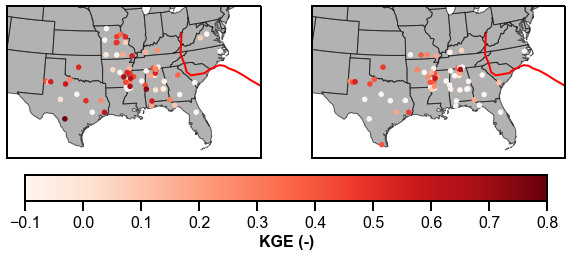

In [794]:
gauge_x= [gdf_gauge.loc[gdf_gauge.ID==_id, 'Longitude'] for _id in df_gauge.columns.tolist()]
gauge_y= [gdf_gauge.loc[gdf_gauge.ID==_id, 'Latitude'] for _id in df_gauge.columns.tolist()]

fig, axes= plt.subplots(1,2,figsize=(10, 8),
                        subplot_kw={'projection': proj},
                        gridspec_kw={'hspace':0.01},
                        facecolor='white')
ax1= axes[0]
gauge_smap= np.array([metrics[key][0] for key in metrics.keys()])
map=ax1.scatter(gauge_x, gauge_y, c=gauge_smap,  cmap='Reds',
           transform=cartopy.crs.PlateCarree(),
                vmin=-0.1, vmax=0.8, s=20)
ax1.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='grey', zorder=0)
tracks= np.array(dict_hurricanes[EVENT]['points'])
ax1.plot(tracks[:,0], tracks[:,1], 'r', transform=cartopy.crs.PlateCarree())
ax1.set_extent([-107, -74, 24, 41]);

ax2= axes[1]
gauge_cyg= np.array([metrics[key][1] for key in metrics.keys()])
map=ax2.scatter(gauge_x, gauge_y, c=gauge_cyg,  cmap='Reds',
           transform=cartopy.crs.PlateCarree(),
                vmin=-0.1, vmax=0.8, s=20)
ax2.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='grey', zorder=0)
tracks= np.array(dict_hurricanes[EVENT]['points'])
ax2.plot(tracks[:,0], tracks[:,1], 'r', transform=cartopy.crs.PlateCarree())
ax2.set_extent([-107, -74, 24, 41]);
cb= fig.colorbar(ax=axes, orientation='horizontal', mappable=map, fraction=0.06, pad=0.04)
cb.set_label('KGE (-)');
# for i in range(len(time)):
    

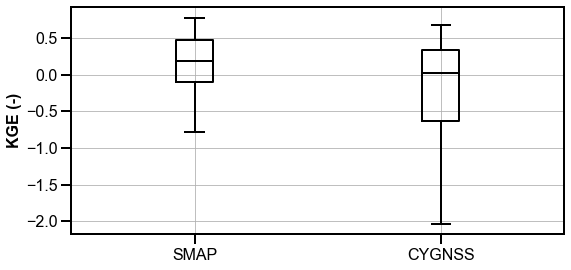

In [781]:
fig= plt.figure(figsize=(8,4), facecolor='white')
ax= fig.add_subplot(111)
ax=pd.DataFrame(metrics).T.plot(kind='box',ax=ax, showfliers=False, flierprops={'linewidth':2},
                               medianprops={'linewidth':2, 'color':'k'}, capprops={'linewidth':2},
                               whiskerprops={'linewidth':2}, boxprops={'linewidth':2})
ax.set_ylabel('KGE (-)')
ax.set_xticks([1,2])
ax.grid()
ax.set_xticklabels(['SMAP', 'CYGNSS']);

In [826]:
ts= get_ts(2013)

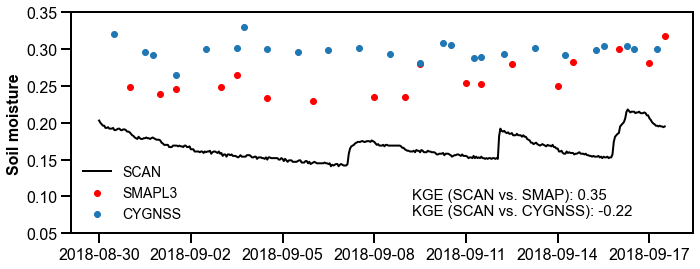

In [843]:
fig= plt.figure(figsize=(10,4))
plt.plot(ts.index, ts.obs/100., 'k', label='SCAN')
plt.scatter(ts.index, ts.smap, c='r', label='SMAPL3')
plt.scatter(ts.index, ts.cygnss, label='CYGNSS')
plt.ylabel('Soil moisture')
plt.legend(loc= 'lower left', frameon=False)
plt.ylim([0.05, 0.35])
plt.text(0.7,0.04,'KGE (SCAN vs. SMAP): 0.35\nKGE (SCAN vs. CYGNSS): -0.22', transform=ax.transAxes)
plt.xticks(ts.index[::72]);

In [4]:
import pytesmo

In [7]:
import ismn.interface as ismn

In [23]:
# path_to_ismn_data = "data" / "ismn" / "multinetwork" / "header_values"

#Initialize reader
ISMN_reader = ismn.ISMN_Interface('data')
# list(ISMN_reader.stations_that_measure('soil_moisture'))

Found existing ismn metadata in data/python_metadata/data.csv.


(None, <GeoAxesSubplot:>, (5, 216, 2449))

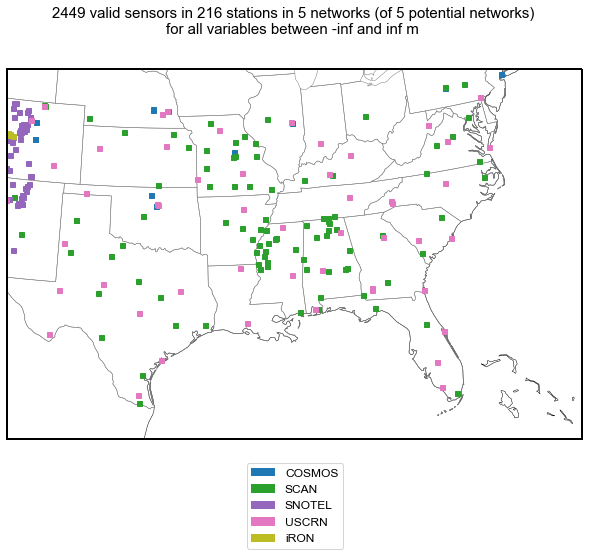

In [39]:
fig=plt.figure(figsize=(12,8))
ax= fig.add_subplot(111, projection=proj)

ISMN_reader.plot_station_locations(ax=ax, text_scalefactor=3,markersize=5)
ax.set_extent([-105,-74,24,41])
# ax.set_ylim([24,41])

In [184]:
# calculate statistics
metrics={}
for stn in ISMN_reader.stations_that_measure('soil_moisture'):
    lon= stn.lon; lat=stn.lat
    if AOI.contains(gpd.GeoDataFrame(geometry=gpd.points_from_xy([lon], [lat])).set_crs('epsg:4326'))[0]:
        _smap= ds.sm_smap.sel(lon=lon,lat=lat,method='nearest').sel(time_smap=slice('2018-08-30 06:00:00',
                                                                                   '2018-09-17 18:00:00'))
        _cyg= ds.sm_cygnss.sel(lon=lon,lat=lat,method='nearest').sel(time_cygnss=slice('2018-08-30 06:00:00',
                                                                                   '2018-09-17 18:00:00'))
        obs= stn.get_sensors('soil_moisture', 0, 1)[0].read_data()
        kge_smap= cal_KGE({'datetime':pd.to_datetime(_smap.time_smap.values),
                          'value': _smap.values.squeeze()}, 
                          {'datetime': obs.loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].index,
                          'value': obs.loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].soil_moisture.squeeze()})
        kge_cygnss= cal_KGE({'datetime':pd.to_datetime(_cyg.time_cygnss.values),
                          'value': _cyg.values.squeeze()}, 
                          {'datetime': obs.loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].index,
                          'value': obs.loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].soil_moisture.squeeze()})
        scaled_smap= pytesmo.scaling.gen_cdf_match(_smap.values, np.array([np.nanquantile(_smap.values,q) for q in np.arange(0.1,1,0.1)]),
                              np.array([obs.soil_moisture.quantile(q) for q in np.arange(0.1,1,0.1)]))
        scaled_cygnss= pytesmo.scaling.gen_cdf_match(_cyg.values, np.array([np.nanquantile(_cyg.values, q) for q in np.arange(0.1,1,0.1)]),
                              np.array([obs.soil_moisture.quantile(q) for q in np.arange(0.1,1,0.1)]))
        kge_scaled_smap= cal_KGE({'datetime':pd.to_datetime(_smap.time_smap.values),
                          'value': scaled_smap}, 
                          {'datetime': obs.loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].index,
                          'value': obs.loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].soil_moisture.squeeze()})
        kge_scaled_cygnss= cal_KGE({'datetime':pd.to_datetime(_cyg.time_cygnss.values),
                          'value': scaled_cygnss}, 
                          {'datetime': obs.loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].index,
                          'value': obs.loc['2018-08-30 06:00:00':'2018-09-17 18:00:00'].soil_moisture.squeeze()})        
        metrics[stn.name]= [kge_smap, kge_cygnss,kge_scaled_smap,kge_scaled_cygnss, lon, lat]

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  # Remove the CWD from sys.path while we load stuff.
/home/ZhiLi/.conda/envs/

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


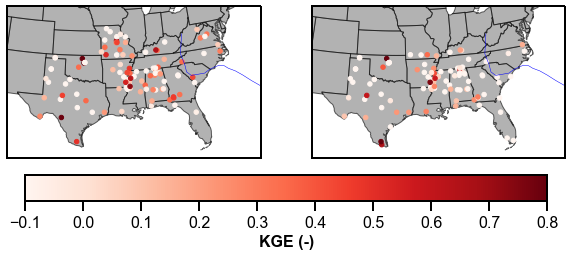

In [134]:
gauge_x= [metrics[key][-2] for key in metrics]
gauge_y= [metrics[key][-1] for key in metrics]

fig, axes= plt.subplots(1,2,figsize=(10, 8),
                        subplot_kw={'projection': proj},
                        gridspec_kw={'hspace':0.01},
                        facecolor='white')
ax1= axes[0]
gauge_smap= np.array([metrics[key][0] for key in metrics.keys()])
map=ax1.scatter(gauge_x, gauge_y, c=gauge_smap,  cmap='Reds',
           transform=cartopy.crs.PlateCarree(),
                vmin=-0.1, vmax=0.8, s=20)
ax1.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='grey', zorder=0)
tracks= np.array(dict_hurricanes[EVENT]['points'])
ax1.plot(tracks[:,0], tracks[:,1], 'b', transform=cartopy.crs.PlateCarree(), linewidth=0.5)
ax1.set_extent([-107, -74, 24, 41]);

ax2= axes[1]
gauge_cyg= np.array([metrics[key][1] for key in metrics.keys()])
map=ax2.scatter(gauge_x, gauge_y, c=gauge_cyg,  cmap='Reds',
           transform=cartopy.crs.PlateCarree(),
                vmin=-0.1, vmax=0.8, s=20)
ax2.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='grey', zorder=0)
tracks= np.array(dict_hurricanes[EVENT]['points'])
ax2.plot(tracks[:,0], tracks[:,1], 'b', transform=cartopy.crs.PlateCarree(), linewidth=0.5)
ax2.set_extent([-107, -74, 24, 41]);
cb= fig.colorbar(ax=axes, orientation='horizontal', mappable=map, fraction=0.06, pad=0.04)
cb.set_label('KGE (-)');
# for i in range(len(time)):
    

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


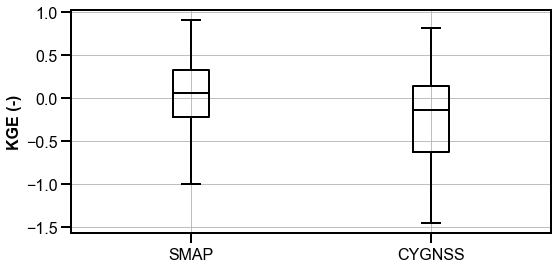

In [135]:
fig= plt.figure(figsize=(8,4), facecolor='white')
ax= fig.add_subplot(111)
ax=pd.DataFrame(metrics).T.iloc[:,:2].plot(kind='box',ax=ax, showfliers=False, flierprops={'linewidth':2},
                               medianprops={'linewidth':2, 'color':'k'}, capprops={'linewidth':2},
                               whiskerprops={'linewidth':2}, boxprops={'linewidth':2})
ax.set_ylabel('KGE (-)')
ax.set_xticks([1,2])
ax.grid()
ax.set_xticklabels(['SMAP', 'CYGNSS']);

## BIAS corrected

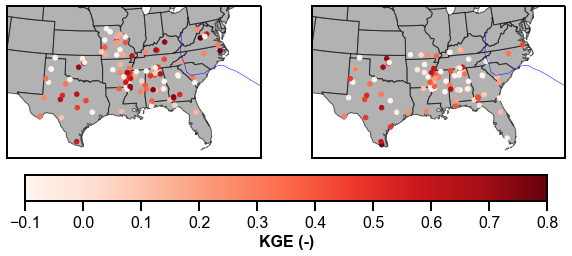

In [186]:
gauge_x= [metrics[key][-2] for key in metrics]
gauge_y= [metrics[key][-1] for key in metrics]

fig, axes= plt.subplots(1,2,figsize=(10, 8),
                        subplot_kw={'projection': proj},
                        gridspec_kw={'hspace':0.01},
                        facecolor='white')
ax1= axes[0]
gauge_smap= np.array([metrics[key][2] for key in metrics.keys()])
map=ax1.scatter(gauge_x, gauge_y, c=gauge_smap,  cmap='Reds',
           transform=cartopy.crs.PlateCarree(),
                vmin=-0.1, vmax=0.8, s=20)
ax1.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='grey', zorder=0)
tracks= np.array(dict_hurricanes[EVENT]['points'])
ax1.plot(tracks[:,0], tracks[:,1], 'b', transform=cartopy.crs.PlateCarree(), linewidth=0.5)
ax1.set_extent([-107, -74, 24, 41]);

ax2= axes[1]
gauge_cyg= np.array([metrics[key][3] for key in metrics.keys()])
map=ax2.scatter(gauge_x, gauge_y, c=gauge_cyg,  cmap='Reds',
           transform=cartopy.crs.PlateCarree(),
                vmin=-0.1, vmax=0.8, s=20)
ax2.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='grey', zorder=0)
tracks= np.array(dict_hurricanes[EVENT]['points'])
ax2.plot(tracks[:,0], tracks[:,1], 'b', transform=cartopy.crs.PlateCarree(), linewidth=0.5)
ax2.set_extent([-107, -74, 24, 41]);
cb= fig.colorbar(ax=axes, orientation='horizontal', mappable=map, fraction=0.06, pad=0.04)
cb.set_label('KGE (-)');
# for i in range(len(time)):
    

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


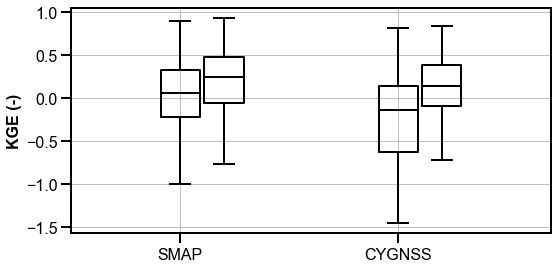

In [198]:
fig= plt.figure(figsize=(8,4), facecolor='white')
ax= fig.add_subplot(111)
ax=pd.DataFrame(metrics).T.iloc[:,[0,2,1,3]].plot(kind='box',ax=ax, showfliers=False, flierprops={'linewidth':2},
                               medianprops={'linewidth':2, 'color':'k'}, capprops={'linewidth':2},
                               whiskerprops={'linewidth':2}, boxprops={'linewidth':2},
                                                  color=['k','r','k','r'],positions=[1, 1.2, 2, 2.2])
# ax=pd.DataFrame(metrics).T.iloc[:,2:4].plot(kind='box',ax=ax, showfliers=False, flierprops={'linewidth':2},
#                                medianprops={'linewidth':2, 'color':'k'}, capprops={'linewidth':2},
#                                whiskerprops={'linewidth':2}, boxprops={'linewidth':2}, positions=[1.2, 2.2])
ax.set_ylabel('KGE (-)')
ax.set_xticks([1,2])
ax.grid()
ax.set_xticklabels(['SMAP', 'CYGNSS']);

In [152]:
def get_ts(name):
    mask= [True if stn.name==name else False for stn in ISMN_reader.stations_that_measure('soil_moisture')]
    stn= np.array(list(ISMN_reader.stations_that_measure('soil_moisture')))[mask][0]
    lon= stn.lon; lat=stn.lat
    _smap= ds.sm_smap.sel(lon=lon,lat=lat,method='nearest').sel(time_smap=slice('2018-08-30 06:00:00',
                                                                               '2018-09-17 18:00:00'))
    _cyg= ds.sm_cygnss.sel(lon=lon,lat=lat,method='nearest').sel(time_cygnss=slice('2018-08-30 06:00:00',
                                                                               '2018-09-17 18:00:00'))
    obs= stn.get_sensors('soil_moisture', 0, 1)[0].read_data()
#     _,left_ind, right_ind= np.intersect1d(obs.index, _cyg.time_cygnss.values,return_indices=True)
    df= pd.DataFrame(index= pd.date_range('2018-08-30 00:00:00','2018-09-18 00:00:00', freq='H'))
    df.loc[df.index.intersection(obs.index),'obs']= obs.loc[df.index.intersection(obs.index)].soil_moisture.squeeze()
    df.loc[_smap.time_smap.values,'smap']= _smap.values.squeeze()
    df.loc[_cyg.time_cygnss.values, 'cygnss']= _cyg.values.squeeze()
    
    return df

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

# df_metrics= pd.DataFrame(metrics).T
# df_metrics.rename(columns={0: 'KGE_SMAP', 1: 'KGE_CYGNSS', 2:'KGE_scaled_SMAP',
#                           3: 'KGE_scaled_CYGNSS', 4: 'lon', 5: 'lat'}).to_csv('data/metrics_0109.csv')

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


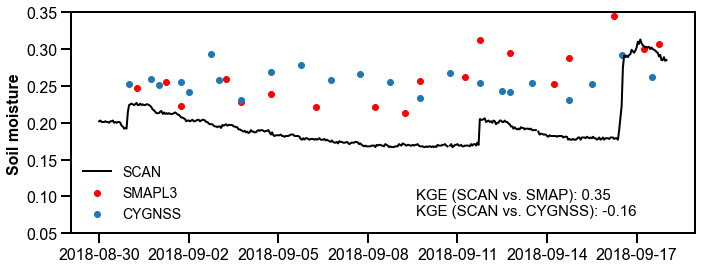

In [159]:
ts= get_ts('Asheville_13_S')
fig= plt.figure(figsize=(10,4))
plt.plot(ts.index, ts.obs, 'k', label='SCAN')
plt.scatter(ts.index, ts.smap, c='r', label='SMAPL3')
plt.scatter(ts.index, ts.cygnss, label='CYGNSS')
plt.ylabel('Soil moisture')
plt.legend(loc= 'lower left', frameon=False)
plt.ylim([0.05, 0.35])
plt.text(0.7,0.04,'KGE (SCAN vs. SMAP): 0.35\nKGE (SCAN vs. CYGNSS): -0.16', transform=ax.transAxes)
plt.xticks(ts.index[::72]);

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  if __name__ == '__main__':


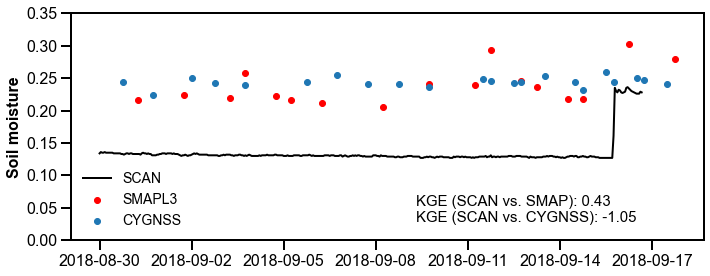

In [162]:
ts= get_ts('Blackville_3_W')
fig= plt.figure(figsize=(10,4))
plt.plot(ts.index, ts.obs, 'k', label='SCAN')
plt.scatter(ts.index, ts.smap, c='r', label='SMAPL3')
plt.scatter(ts.index, ts.cygnss, label='CYGNSS')
plt.ylabel('Soil moisture')
plt.legend(loc= 'lower left', frameon=False)
plt.ylim([0, 0.35])
plt.text(0.7,0.04,'KGE (SCAN vs. SMAP): 0.43\nKGE (SCAN vs. CYGNSS): -1.05', transform=ax.transAxes)
plt.xticks(ts.index[::72]);

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  if __name__ == '__main__':


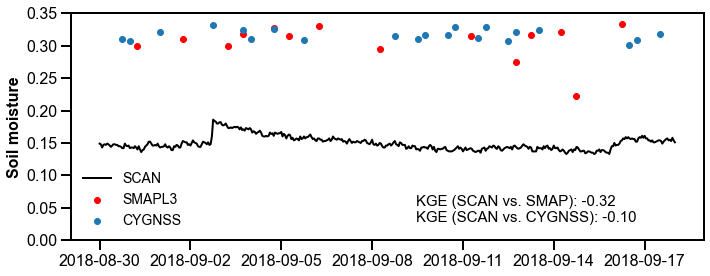

In [164]:
ts= get_ts('Youmans_Farm')
fig= plt.figure(figsize=(10,4))
plt.plot(ts.index, ts.obs, 'k', label='SCAN')
plt.scatter(ts.index, ts.smap, c='r', label='SMAPL3')
plt.scatter(ts.index, ts.cygnss, label='CYGNSS')
plt.ylabel('Soil moisture')
plt.legend(loc= 'lower left', frameon=False)
plt.ylim([0, 0.35])
plt.text(0.7,0.04,'KGE (SCAN vs. SMAP): -0.32\nKGE (SCAN vs. CYGNSS): -0.10', transform=ax.transAxes)
plt.xticks(ts.index[::72]);

In [168]:
import pytesmo.scaling

In [260]:
ts= get_ts('Blackville_3_W')
scaled_smap= pytesmo.scaling.gen_cdf_match(ts.smap.values, np.array([ts.smap.quantile(q) for q in np.arange(0.1,1,0.1)]),
                              np.array([ts.obs.quantile(q) for q in np.arange(0.1,1,0.1)]))
scaled_cyg= pytesmo.scaling.gen_cdf_match(ts.cygnss.values, np.array([ts.cygnss.quantile(q) for q in np.arange(0.1,1,0.1)]),
                              np.array([ts.obs.quantile(q) for q in np.arange(0.1,1,0.1)]))

/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Function get_sensors is deprecated and will be removed in future version of ismn.
  if __name__ == '__main__':


/home/ZhiLi/.conda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


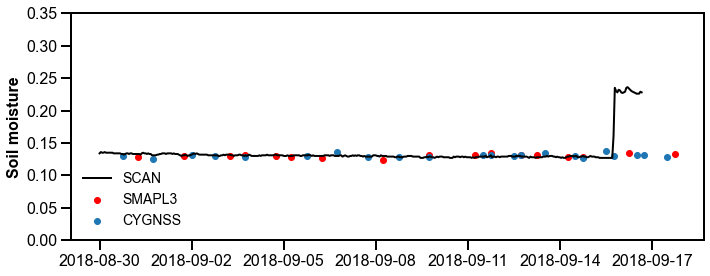

In [261]:

fig= plt.figure(figsize=(10,4))
plt.plot(ts.index, ts.obs, 'k', label='SCAN')
plt.scatter(ts.index, scaled_smap, c='r', label='SMAPL3')
plt.scatter(ts.index, scaled_cyg, label='CYGNSS')
plt.ylabel('Soil moisture')
plt.legend(loc= 'lower left', frameon=False)
plt.ylim([0, 0.35])
# plt.text(0.7,0.04,'KGE (SCAN vs. SMAP): -0.32\nKGE (SCAN vs. CYGNSS): -0.10', transform=ax.transAxes)
plt.xticks(ts.index[::72]);